# Projet 2 Participez à un concours sur la Smart City

## Jupyter Notebook

Nous utilisons ce programme, qui est un outil informatique de logiciel libre, et basé sur IPython. Il vous permettra de lire les commentaires écrit au format markdown, et d'interpréter les cellules de code, ici en Python. Mais cette technologie marche avec d'autres langages, Scala notamment. Pour l'usage de la bibliothèque PyCuda, des librairies C associées, il est important d'utiliser Anaconda comme environnement de travail, car un environnement virtuel ne peut facilement se configurer pour PyCuda.

## Pandas

Nous utiliserons le langage Python, conformément à la consigne, et nous importerons la bibliothèque de manipulation des données Pandas. Ensuite nous importerons quelques autres, pour travailler par exemple avec des matrices.

## PyCuda

Nous utilisons un gpu pour calculer le chemin le plus court entre les arbres que notre client sera supposé surveillé à partir de notre synthèse. Le nombre de lieu étant de 6921, il nous fallait un gpu pour calculer la distance en km et à vol d'oiseau entre les coordonnées de chaque lieu référençant un groupe d'arbre à une adresse dans chaque arrondissement.

## Importation des bibliothèques

In [1]:
import datashader as ds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandasql as ps
import seaborn as sns
import sklearn
import panel as pn

from bokeh.io import save
import colorcet
import itertools
import folium
import math
import openpyxl
import os
import pickle
import random
import scipy
import selenium            
import christofides

from collections import OrderedDict, deque
from IPython.display import HTML as html_print
from seaborn import color_palette
from sklearn import preprocessing


# 1) Présentation générale du jeu de données

## Data requirements

La ville de Paris veut optimiser ses tournées, il s'agit d'un problème d'algorithmie courant : ***Problème du voyageur de commerce***. Aujourd'hui ce calcul peut s'effectuer avec plusieurs millions de ville sans que cela ne prenne trop de temps de calcul. La ville de Paris met à notre disposition les positions de chaque emplacement et leur nom, de sorte que si nous considérons que le réseau de Paris est assez dense pour que nous puissions négliger les sinuosités de la route, nous pouvons calculer la distance à vol d'oiseau, entre les emplacements. Et en prenant l'emplacement le plus proche de l'emplacement ou nous sommes, nous pouvons espérer trouver ainsi le plus court chemin pour parvenir à notre objectif de tournée. Sachant que nous pouvons cibler une tournée spécialement pour par exemple les sequoias qui sera la plus courte possible. Nous utiliserons l'algorithme de christofides

Ensuite nous chercherons à optimiser les usages de produits phytosanitaires. Et après cela, nous voudrions proposer une solution d'optimisation pour l'utilisation des outils.

## Data collection

Nous récupérons les données depuis une seule source, un fichier "comma separator value" ou csv, [à cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+2+Participez+%C3%A0+un+concours+sur+la+Smart+City/p2-arbres-fr.csv). Nous plaçons ensuite le fichier dans le répertoire de travail et nous vérifions le nombre de séparateur ';' par ligne, un simple sanity-check. Ensuite pour l'importer dans la partie suivante nous utilisons la bibliothèque pandas. Cependant, nous sérialiserons avec la bibliothèque pickle dans le stockage de données kilomètrique pour la partie sur les trajets.

Ce jeu de données comporte $17$ colonnes. $200137$ lignes et $646164$ valeurs manquantes. La colonne 'numéro' est inutilisable, et celle des id ne démarre pas à *0*. Plus d'information seront détaillées dans les paragraphes suivants.

## Data processing

Nous obtenons les données dans le bon format, mais avec quelques erreurs, nous verrons cela plus tard, pour l'instant nous importons nos données en indiquant le séparateur, et sans indiquer de colonne servant à indexer la table de nos données pour la régénérer automatiquement. Nous remplaçons ainsi la colonne d'indexation par un index à l'incrémentation parfaite. Nous éliminons les colonnes reliquat d'id et de numero qui ne sont pas intéressantes pour nos observations.

Ensuite nous remplacerons les valeurs nulles de la colonnes remarquable par des 0, car nous pouvons estimer que seul à partir du moment ou un arbre est noté 1 dans cette colonne, il devient remarquable. Nous convertissons ensuite la table remarquable en booléen.

Ensuite pour la colonne stade de développement, nous remarquons qu'il manque une valeur, pour des arbres qui pourraient faire partie de deux catégories. Nous appelons cette nouvelle catégorie 'P' pour produit.

Puis pour la colonne domanialité, nous rajoutons l'appelation 'Jardin' à une ligne dont l'adresse indique que c'est dans des jardins d'une résidence.

Ensuite, pour la colonne variété, nous inscrivons 'n. sp.' pour non spécifié dans les emplacements manquants. De même pour la colonne 'espèce'.

Pour la données 'stade de développement' nous avons créer une colonne 'sta_dev_num' qui associe une valeur d'ordre pour ordonnée ces données selon le niveau de maturité de l'âge, et ainsi transformant cette catégorie en une catégorie ordonnée.

In [2]:
data = pd.read_csv('data.csv', sep=';')
data.drop('id', axis=1, inplace=True)
#data.drop('numero', axis=1, inplace=True)

## Data cleaning

Nous devons contrôler les doublons, les valeurs nulles, les données incomplètes, les erreurs et les données manquantes. Nous réglons les types, pour obtenir des valeurs à mettre en base de données, au besoin.
Voilà comment se présentent les données sorties du fichier.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  object 
 1   domanialite          200136 non-null  object 
 2   arrondissement       200137 non-null  object 
 3   complement_addresse  30902 non-null   object 
 4   numero               0 non-null       float64
 5   lieu                 200137 non-null  object 
 6   id_emplacement       200137 non-null  object 
 7   libelle_francais     198640 non-null  object 
 8   genre                200121 non-null  object 
 9   espece               198385 non-null  object 
 10  variete              36777 non-null   object 
 11  circonference_cm     200137 non-null  int64  
 12  hauteur_m            200137 non-null  int64  
 13  stade_developpement  132932 non-null  object 
 14  remarquable          137039 non-null  float64
 15  geo_point_2d_a   

### Les valeurs nulles, les types.

Nous remplaçons les valeurs nulles de la colonne "remarquable" par la valeur -1 (qui code pour non-saisie), et pouvons le convertir en entier ensuite.

In [4]:
data['remarquable'].fillna(value=-1, inplace=True)
data['remarquable'] = data['remarquable'].map({0.:False, 1.:True})
data['remarquable'] = data['remarquable'].convert_dtypes(convert_integer=True)

Pour les colonnes "arrondissement"…, qui n'ont pas de valeurs nulles, nous forçons la conversion

In [5]:
colonnes = ['arrondissement', 'type_emplacement', 'lieu', 'id_emplacement']
for col in colonnes:
    data[col] = data[col].convert_dtypes(convert_string=True)

Pour les colonnes "stade_developpement"…, comme ce sont des strings, nous remplaçons les valeurs nulles par deux quote.

In [6]:
colonnes = ['stade_developpement', 'espece', 'variete', 'genre', 'libelle_francais',\
            'complement_addresse', 'domanialite']
for col in colonnes:
    data[col].fillna(value="", inplace=True)
    data[col] = data[col].convert_dtypes(convert_string=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  string 
 1   domanialite          200137 non-null  string 
 2   arrondissement       200137 non-null  string 
 3   complement_addresse  200137 non-null  string 
 4   numero               0 non-null       float64
 5   lieu                 200137 non-null  string 
 6   id_emplacement       200137 non-null  string 
 7   libelle_francais     200137 non-null  string 
 8   genre                200137 non-null  string 
 9   espece               200137 non-null  string 
 10  variete              200137 non-null  string 
 11  circonference_cm     200137 non-null  int64  
 12  hauteur_m            200137 non-null  int64  
 13  stade_developpement  200137 non-null  string 
 14  remarquable          137039 non-null  boolean
 15  geo_point_2d_a   

## Résolution des données manquantes :

De plus nous remarquons qu'une ligne ne comporte pas de domanialité, mais qu'il semble d'après son lieu, que ce soit un jardin.

In [8]:
data.loc[data['domanialite'] == ""]

,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
197239,Arbre,,PARIS 20E ARRDT,,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,203006,Chimonanthe,Chimonanthus,praecox,,35,4,JA,False,48.849547,2.41419


In [9]:
mask = data['domanialite'] == ''
data.loc[mask,'domanialite'] = 'Jardin'

In [10]:
data.iloc[197239]

type_emplacement                                                   Arbre
domanialite                                                       Jardin
arrondissement                                           PARIS 20E ARRDT
complement_addresse                                                     
numero                                                               NaN
lieu                   JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...
id_emplacement                                                    203006
libelle_francais                                             Chimonanthe
genre                                                       Chimonanthus
espece                                                           praecox
variete                                                                 
circonference_cm                                                      35
hauteur_m                                                              4
stade_developpement                                

De même pour la variété, pour 63000 arbres :

In [11]:
mask = data['variete'] == ''
data.loc[mask,'variete'] = 'n. sp.'
mask = data['espece'] == ''
data.loc[mask,'espece'] = 'n. sp.'
mask = data['libelle_francais'] == ''
data.loc[mask,'libelle_francais'] = 'n. sp.'
mask = data['genre'] == ''
data.loc[mask,'genre'] = 'n. sp.'

De plus pour la légende des stades de développement, nous rajoutons la P, pour particulier, car il représente une masse d'arbre qui sorte des statistiques pour la moitié d'entre eux. Cette catégorie passe de 60000 arbres à 30000 arbres après filtrage des hauteurs et des circonférences. Cette catégorie semble regroupé des arbres de catégories JA et J.

In [12]:
data.stade_developpement = data.stade_developpement.map({'':'P', 'A':'A','JA':'JA','M':'M','J':'J'})

In [13]:
data['stade_developpement'] = data['stade_developpement'].convert_dtypes()

In [14]:
data.stade_developpement.unique()

<StringArray>
['P', 'A', 'J', 'M', 'JA']
Length: 5, dtype: string

Comme la colonne de stade de développement est une variable qualitative ordonnée, nous créons une colonne de sa valeur en chiffre pour un usage quantitatif de la variable car l'âge est quantitatif.

In [15]:
data['sta_dev_num'] = data.stade_developpement.map({'J':1, 'P':2, 'JA':3, 'A':4, 'M':5})

## Résolution des données aberrantes

Notre analyse va nous servir à détecter les erreurs dans la base de données, qui sont autant anomalies ("outliers") ou de données aberrantes qui peuvent nous conduire à de fausses conclusions sur les éléments de notre analyse. Nous analyserons les colonnes circonférence en centimètre, et hauteur en mètre. Les ordres de grandeurs sont indiqués dans les lignes min/max du tableau ci-dessous. À noter que nous commençons d'abord par décrire les données sans filtres :

In [16]:
data[['circonference_cm','hauteur_m']].describe()

,circonference_cm,hauteur_m
count,200137.000000,200137.000000
mean,83.380479,13.110509
std,673.190213,1971.217387
min,0.000000,0.000000
25%,30.000000,5.000000
50%,70.000000,8.000000
75%,115.000000,12.000000
max,250255.000000,881818.000000


### Intervalle interquartile

$Q_i = Q_3 - Q_1$ nous donne l'intervalle interquartile. L'intervalle minimum de confiance est $Q_i \times 1.5$, c'est la limite intérieur. De plus l'intervalle maximum de confiance est $Q_i \times 3$. Nous réglons nos bornes selon cette formule : pour la circonférence le maximum est $255$, alors que pour la hauteur le maximum est $21$.

Ci-dessus, la ligne max nous permet de raisonner sur la présence d'aberrations et dans les prochains paragraphes, en ajustant les valeurs d'exclusions en multipliant par 3,5 , nous allons faire une analyse univariée pour la circonférence et la hauteur des arbres de la ville de Paris. Nous avons pris la circonférence entre $]0, 255] centimètres$, la hauteur entre $]0, 21] mètres$, puis les remarquables avec une valeur Vrai (dans un cas spécialement adapté ou la corrélation est évaluée entre la hauteur et la circonférence).

#### La circonférence

D'après le graphique et les résultats qui suivent, la circonférence de la population est une distribution dont le maximum est de $400 cm$ pour une moyenne de 91 cm et un écart type de $57,59 cm$ de part et d'autre de la moyenne. L'allure et la répartition de la distribution de la population est une asymétrie vers la droite, et le plus fréquemment, la circonférence est de 20 cm. L'échantillon considéré est de $174026$ arbres.

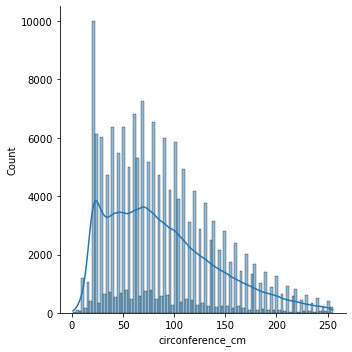

In [17]:
a = data.loc[(data["circonference_cm"] <= 255) & (data["circonference_cm"] > 0)]
sns.displot(data=a, x="circonference_cm", kde=True)

In [18]:
a["circonference_cm"].describe()

count    171801.000000
mean         88.451965
std          52.976410
min           1.000000
25%          45.000000
50%          80.000000
75%         120.000000
max         255.000000
Name: circonference_cm, dtype: float64

In [19]:
a["circonference_cm"].mode()

0    20
dtype: int64

In [20]:
scipy.stats.skew(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.7695227895406083

In [21]:
scipy.stats.kurtosis(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.027890140940736163

#### La hauteur

La distribution est irrégulière, mais contient $160122$ arbres après filtrage des données aberrantes. La hauteur maximale est $29 mètres$ et la moyenne est de $10,32 mètres$, tout comme le mode et la médiane. Par contre l'asymétrie est positive, donc vers la droite mais sa valeur est inférieur à $1$, comme l'est aussi son kurtosis. Visuellement, il serait difficile de dire qu'ici s'applique le théorème de limite centrale car nous n'avons pas a première vue une Gaussienne.


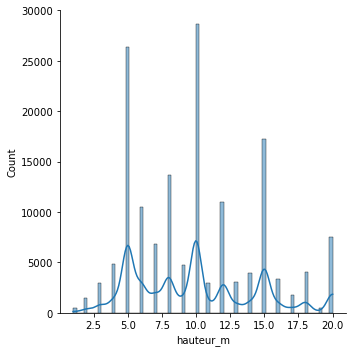

In [22]:
b = data.loc[(data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)]
sns.displot(data=b, x="hauteur_m", kde=True)

In [23]:
b["hauteur_m"].describe()

count    155743.000000
mean          9.928016
std           4.546542
min           1.000000
25%           6.000000
50%          10.000000
75%          13.000000
max          20.000000
Name: hauteur_m, dtype: float64

In [24]:
b["hauteur_m"].mode()

0    10
dtype: int64

In [25]:
scipy.stats.skew(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

0.4872105232672621

In [26]:
scipy.stats.kurtosis(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

-0.6014377033875058

#### Régression linéaire entre la hauteur et la circonférence

En considérant l'expression de la circonférence d'après la hauteur, nous pouvons constater une corrélation positive entre le données quantitative, autant pour les arbres remarquables, que les premiers. Ainsi nous définissons les données filtrées dans une variable par copy profonde.

In [27]:
data_filtre = data.loc[((data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)) \
                          & ((data["circonference_cm"] < 255) & (data["circonference_cm"] > 0))].copy()
data_filtre.to_excel('data/data_filtre.xlsx')

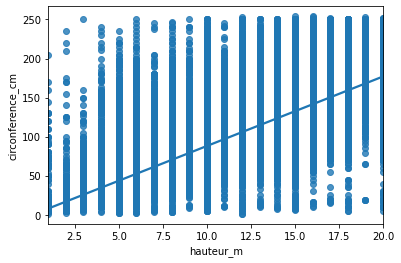

In [28]:
sns.regplot( x="hauteur_m", y="circonference_cm", data=data_filtre);

Si nous ajoutons les variables indépendantes circonférence, hauteur pour les arbres remarquables, nous pourrions sans doute appliquer le théorème de limite centrale sur nos données ainsi filtrés tant les courbes ont une forme dont la régularité s'approche plus d'une gaussienne. Peut-être nous restera-t-il à croiser les données avec d'autres pour affiner la courbe en forme de cloche.

#### Construire une table d'information personnalisée

Il est possible de se passer de la méthode info pour construire un algorithme plus puissant afin d'observer le plus d'information sur les tables :

In [29]:
def informations(data):
    # Header
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('#' , '|' , 'Column', '|', 'Dtype', '|', 'Unique', '|', 'Count Non-Null','|','Mean','|','Std','|'))
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('---' , '|' , '------', '|', '-----', '|', '------', '|', '--------------','|','----','|','---','|'))
    # dtypes information
    dtypes_uniques = set() # Collection of unique elements
    dtypes_listes = [] # list of complete data columns
    memory_usage = 0 # in MB
    for it, col in enumerate(data.columns): # Feed the set and the list
        dtypes_listes.append(str(data[col].dtype))
        if str(data[col].dtype) not in dtypes_uniques:
            dtypes_uniques.add(str(data[col].dtype))
        # Table body
        print('{:^3}{:<1}{:<20}{:<1}{:^9}{:>1}{:<6}{:<1}{:<15}{:<1}{:<7.5}{:<1}{:<7.5}{:<1}'.format(\
                                                str(it), '|' , col, '|',\
                                                str(data[col].dtype), '|', str(len(data[col].unique())),\
                                                '|',str(data[col].count()) + ' Non-null','|',\
                                                str(data[col].mean())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|',\
                                                str(data[col].std())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|'))
        
        # Collect informatives on disk usage by observation onto the data column
        memory_usage += int(data[col].memory_usage(index=True, deep=True))
    # Blend of set and list to print the information line as usual
    dtypes_string = ''
    for x in dtypes_uniques:
        dtypes_string += '{}({}), '.format(x, dtypes_listes.count(x))
    print('\ndtypes: {}'.format(dtypes_string))
    # Digit format to write mem usage in comprehensive format
    print('\nmemory usage: {:.4} MB\n'.format(memory_usage / (1024*1024)))

# 2) Démarche méthodologique d'analyse de données

À partir de nos jeux de données produites nous calculons les moyennes et les écarts types par la formules de la fonction information() que nous venons de definir dans la cellule au-dessus



In [30]:
informations(data)

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |type_emplacement    | string  |1     |200137 Non-null|       |       |
 1 |domanialite         | string  |9     |200137 Non-null|       |       |
 2 |arrondissement      | string  |25    |200137 Non-null|       |       |
 3 |complement_addresse | string  |3796  |200137 Non-null|       |       |
 4 |numero              | float64 |1     |0 Non-null     |nan    |nan    |
 5 |lieu                | string  |6921  |200137 Non-null|       |       |
 6 |id_emplacement      | string  |69040 |200137 Non-null|       |       |
 7 |libelle_francais    | string  |193   |200137 Non-null|       |       |
 8 |genre               | string  |176   |200137 Non-null|       |       |
 9 |espece              | string  |539   |200137 Non-null|       |       |
10 |variete             | string  |436   |200137 Non-null|       |       |
11 |circonference_cm    |

In [31]:
informations(data_filtre)

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |type_emplacement    | string  |1     |154067 Non-null|       |       |
 1 |domanialite         | string  |9     |154067 Non-null|       |       |
 2 |arrondissement      | string  |25    |154067 Non-null|       |       |
 3 |complement_addresse | string  |3611  |154067 Non-null|       |       |
 4 |numero              | float64 |1     |0 Non-null     |nan    |nan    |
 5 |lieu                | string  |5389  |154067 Non-null|       |       |
 6 |id_emplacement      | string  |46578 |154067 Non-null|       |       |
 7 |libelle_francais    | string  |170   |154067 Non-null|       |       |
 8 |genre               | string  |146   |154067 Non-null|       |       |
 9 |espece              | string  |375   |154067 Non-null|       |       |
10 |variete             | string  |369   |154067 Non-null|       |       |
11 |circonference_cm    |

Maintenant que nous avons nettoyer nos données, nous pouvons regarder à l'intérieur des catégories, pour apprécier l'hétérogénéité des hauteurs, par exemple selon le stade de développement pour le genre Eucalyptus.

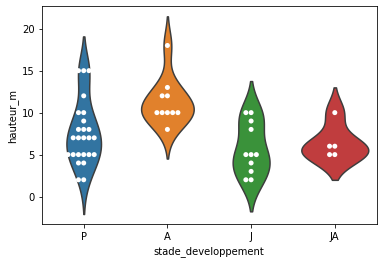

In [32]:
ax = sns.violinplot(x="stade_developpement", y="hauteur_m", data=data_filtre.loc[data_filtre['genre']=='Eucalyptus'], inner=None)

ax = sns.swarmplot(x="stade_developpement", y="hauteur_m", data=data_filtre.loc[data_filtre['genre']=='Eucalyptus'],

                   color="white", edgecolor="gray")

Ou encore voir que les domanialités ont différentes distributions en hauteur pour les platanes.

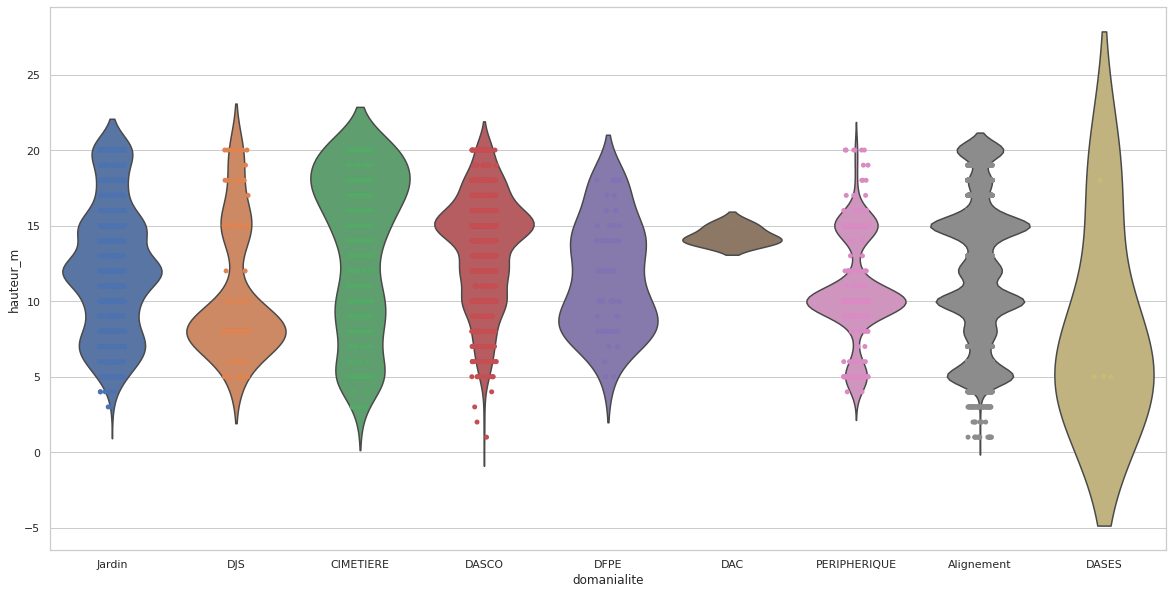

In [79]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="domanialite", y="hauteur_m", data=data_filtre.loc[data_filtre['libelle_francais']=='Platane'], inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
ax = sns.stripplot(x="domanialite", y="hauteur_m", data=data_filtre.loc[data_filtre['libelle_francais']=='Platane'])
#f.savefig('jar.png')

Et même que les domanialités ont différentes distributions en stade de développement. Notons que le périphérique
est très orienté sur un seul stade de développement, celui dont les hauteurs et les circonférences sont autant du groupe 'J' que du groupe 'JA'.

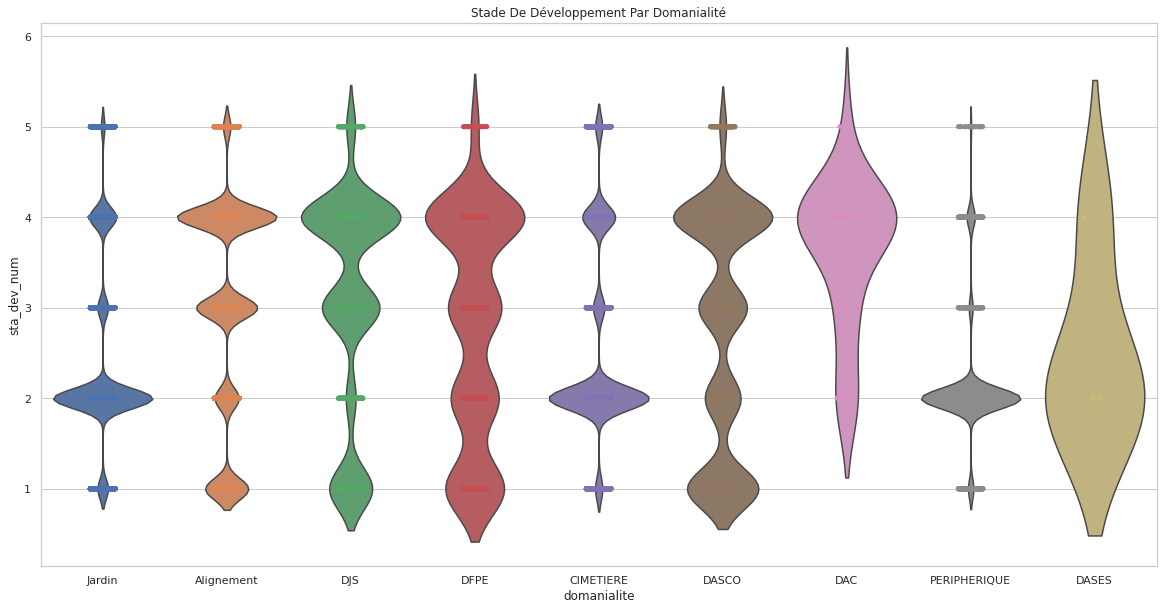

In [78]:
f = plt.figure(figsize=(20 , 10))

ax = sns.violinplot(x="domanialite", y="sta_dev_num", data=data, inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
ax = sns.stripplot(x="domanialite", y="sta_dev_num", data=data).set(title='Stade de développement par domanialité'.title())
#f.savefig('sta_dev_num_domanialite.png')
plt.show()

Nous utilisons un filtre sur la base pour éliminer les arbres dont nous ne sommes pas sur de la hauteur ou de la circonférence, puis avec une requête SQL, nous déterminons le nombre d'individu, dans chaque élément quantitatif à l'intérieur de chaque quartier, excepté pour la domanialité qui est une données de catégorie. Nous ajoutons en plus des moyennes ainsi que des pourcentages du nombre d'arbres. Nous commençons notre analyse quantitative sur $159568$ arbres.

In [36]:
q1 = """SELECT  arrondissement,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data), 2) as "pourcent",
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.arrondissement"""

In [37]:
quant_arr = ps.sqldf(q1, locals())

In [38]:
quant_arr

,arrondissement,pourcent,domani,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,BOIS DE BOULOGNE,1.60,2,18,3209,1761,25,21,42,24,77.65,9.63,0
1,BOIS DE VINCENNES,3.64,2,26,7286,4301,94,83,153,41,87.45,10.65,0
2,HAUTS-DE-SEINE,0.44,1,184,890,890,33,28,41,18,69.99,8.97,0
3,PARIS 10E ARRDT,1.45,5,119,2896,1564,59,43,73,64,79.84,10.26,1
4,PARIS 11E ARRDT,2.69,5,176,5393,2353,90,70,107,75,80.61,10.29,0
5,PARIS 12E ARRDT,5.89,9,287,11791,5188,100,80,168,92,80.57,8.92,7
6,PARIS 13E ARRDT,6.67,7,346,13347,5205,114,95,187,120,78.70,9.08,2
7,PARIS 14E ARRDT,5.50,7,330,11008,6018,113,99,179,129,92.82,8.92,2
8,PARIS 15E ARRDT,5.66,8,307,11319,4831,98,81,151,112,80.82,9.28,5
9,PARIS 16E ARRDT,7.18,7,268,14368,5473,120,106,210,131,87.58,10.43,26


Nous faisons la même chose pour chaque domanialité :

In [39]:
q2 = """SELECT  domanialite,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(stade_developpement)) as devel,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.domanialite"""

In [40]:
quant_dom = ps.sqldf(q2, locals())

In [41]:
quant_dom

,domanialite,pourcent,arrond,devel,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,Alignement,48.43,22,5,1793,96920,7555,97,80,167,124,84.85,10.18,4
1,CIMETIERE,7.88,10,5,1876,15775,13306,125,104,175,101,103.04,10.03,6
2,DAC,0.01,5,4,5,21,21,12,10,10,4,116.05,9.38,1
3,DASCO,3.16,20,5,661,6330,6303,96,74,136,159,78.86,8.29,0
4,DASES,0.00,2,2,2,4,4,1,1,1,1,52.50,8.25,0
5,DFPE,0.63,19,5,228,1256,1255,85,67,106,50,79.99,8.30,0
6,DJS,1.81,16,5,103,3630,3619,101,85,152,86,92.48,8.92,0
7,Jardin,12.49,21,5,535,25002,11429,155,134,338,237,87.97,9.48,65
8,PERIPHERIQUE,2.56,9,5,198,5129,5123,62,55,88,28,78.56,8.59,0


Nous observons que le stade de développement peut indiquer une relation avec les produits à utiliser, donc nous utilisons le stade de développement comme pivot.

In [42]:
q3 = """SELECT  stade_developpement,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.stade_developpement"""

In [43]:
quant_dev = ps.sqldf(q3, locals())

In [44]:
quant_dev

,stade_developpement,pourcent,arrond,domani,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,A,30.17,25,9,3415,60381,19108,132,114,241,140,118.55,12.65,41
1,J,13.18,25,7,2614,26383,10124,132,112,266,255,38.76,5.76,1
2,JA,17.21,25,8,2755,34443,10613,132,109,228,146,70.59,9.02,1
3,M,1.84,25,8,865,3673,2438,69,60,97,29,191.48,16.45,31
4,P,14.58,25,9,2623,29187,17284,151,129,281,258,71.06,8.03,2


Ici nous exprimons les quantités par stade de développement, et par domanialité

In [45]:
q4 = """SELECT  stade_developpement as devel,
                domanialite as domani,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data), 2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.stade_developpement, domanialite
                ORDER BY devel, domani, haut"""

In [46]:
quant_dev_dom = ps.sqldf(q4, locals())

In [47]:
quant_dev_dom

,devel,domani,pourcent,arrond,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,A,Alignement,21.42,22,1374,42863,4855,71,59,112,77,115.42,12.83,2
1,A,CIMETIERE,2.94,9,962,5891,5408,81,71,96,39,137.65,12.96,5
2,A,DAC,0.01,3,3,14,14,7,7,6,3,135.50,11.86,0
3,A,DASCO,1.21,20,524,2419,2416,64,48,71,25,124.68,11.87,0
4,A,DASES,0.00,1,1,1,1,1,1,1,1,150.00,18.00,0
5,A,DFPE,0.24,16,131,486,486,47,38,57,19,115.47,10.77,0
6,A,DJS,0.88,15,91,1765,1763,55,47,76,25,126.12,11.11,0
7,A,Jardin,3.29,21,285,6576,4575,115,101,207,94,117.35,12.05,34
8,A,PERIPHERIQUE,0.18,8,50,366,366,29,25,35,7,124.90,12.09,0
9,J,Alignement,9.52,22,1151,19046,4018,81,65,129,89,40.33,6.06,0


In [48]:
q5 = """SELECT  genre,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(variete)) as variete,
                count(DISTINCT(espece)) as espece,
                ROUND(AVG(sta_dev_num), 2) as cat_age,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data GROUP BY data.genre"""

In [49]:
quant_gen = ps.sqldf(q5, locals())

In [50]:
quant_gen.to_excel('quant_gen.xlsx')

In [51]:
q5 = """SELECT  genre,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(variete)) as variete,
                count(DISTINCT(espece)) as espece,
                ROUND(AVG(sta_dev_num), 2) as cat_age,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtre GROUP BY data_filtre.genre"""

In [52]:
quant_gen_filtre = ps.sqldf(q5, locals())

In [53]:
quant_gen_filtre.to_excel('quant_gen_filtre.xlsx')

In [54]:
quant_gen_filtre

,genre,pourcent,arrond,domani,lieu,arbres,id_empl,libel_fr,variete,espece,cat_age,circon,haut,remarq
0,Abelia,0.00,2,2,2,2,2,1,1,2,3.00,47.50,5.50,0.0
1,Abies,0.03,15,4,26,70,70,1,1,8,2.33,65.09,8.13,0.0
2,Acacia,0.00,2,2,2,6,6,1,2,1,2.00,24.17,5.00,0.0
3,Acca,0.00,1,1,2,2,2,2,2,1,1.50,10.00,1.00,0.0
4,Acer,6.15,25,8,1377,12311,8240,2,47,36,2.89,88.27,9.92,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Viburnum,0.00,2,1,3,3,3,1,1,1,1.67,30.00,5.00,0.0
142,Zanthoxylum,0.01,7,3,8,11,11,1,1,2,2.73,36.82,4.64,0.0
143,Zelkova,0.13,19,7,52,253,247,2,5,5,2.01,55.66,6.75,0.0
144,x Chitalpa,0.01,8,6,13,16,16,2,2,2,1.50,23.44,3.44,0.0


In [55]:
x = quant_gen[['haut','circon','cat_age','arbres']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


# 3) Synthèse de mon analyse

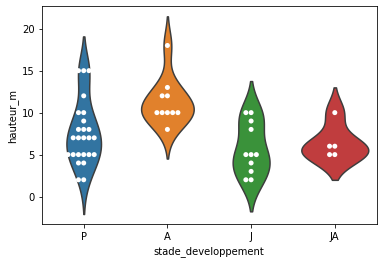

In [56]:
ax = sns.violinplot(x="stade_developpement", y="hauteur_m", data=data_filtre.loc[data_filtre['genre']=='Eucalyptus'], inner=None)

ax = sns.swarmplot(x="stade_developpement", y="hauteur_m", data=data_filtre.loc[data_filtre['genre']=='Eucalyptus'],

                   color="white", edgecolor="gray")

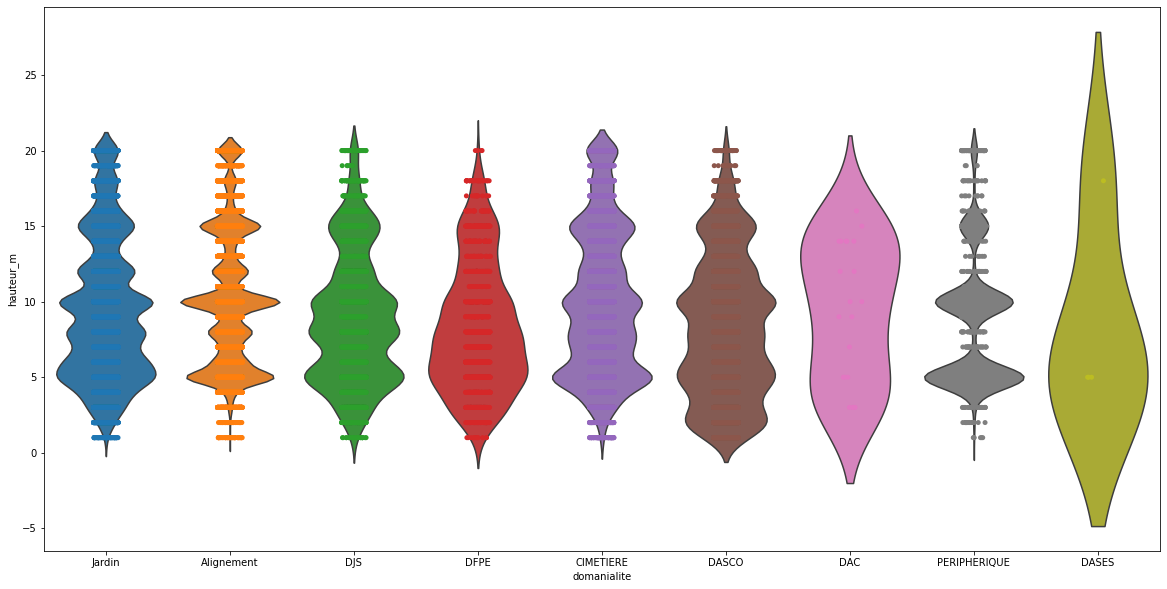

In [57]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="domanialite", y="hauteur_m", data=data_filtre, inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
ax = sns.stripplot(x="domanialite", y="hauteur_m", data=data_filtre)
f.savefig('jar.png')

In [58]:
f = plt.figure(figsize=(20 , 10))

ax = sns.violinplot(x="domanialite", y="sta_dev_num", data=data_filtre, inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
ax = sns.stripplot(x="domanialite", y="sta_dev_num", data=data_filtre).set(title='Title of Plot'.title())
f.savefig('jar.png')
plt.close()

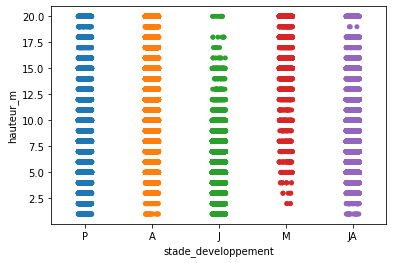

In [59]:
ax = sns.stripplot(x="stade_developpement", y="hauteur_m", data=data_filtre)

<AxesSubplot:xlabel='haut', ylabel='circon'>

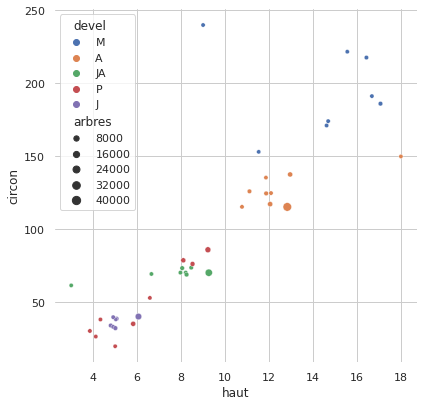

In [60]:
sns.set_theme(style="whitegrid")

df = quant_dev_dom[['haut','circon', 'arbres', 'devel']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="haut", y="circon",
                hue="devel", hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

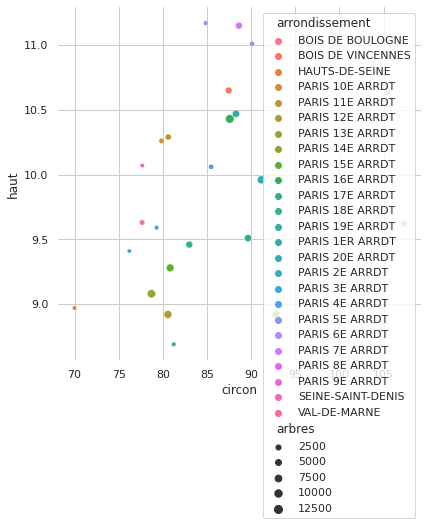

In [61]:
sns.set_theme(style="whitegrid")

df = quant_arr[['haut','circon', 'arbres', 'arrondissement']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="arrondissement", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

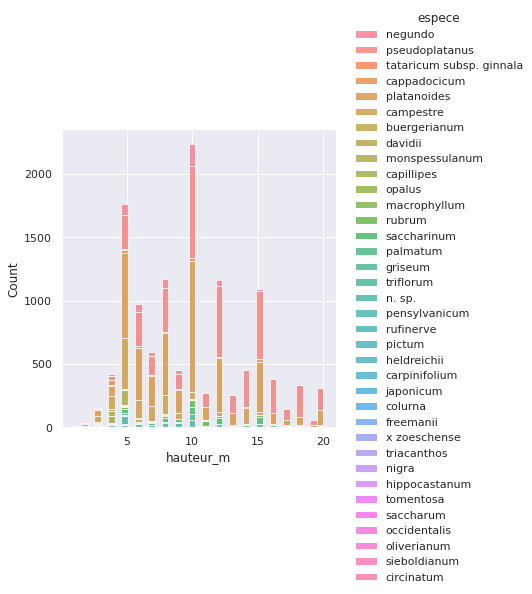

In [62]:
sns.set()
sns_plot = sns.displot(data_filtre.loc[data_filtre['genre'] == 'Acer'], x="hauteur_m", hue="espece", multiple="stack")
sns_plot.savefig("output.png")

/home/romain/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/romain/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='circonference_cm', ylabel='Density'>

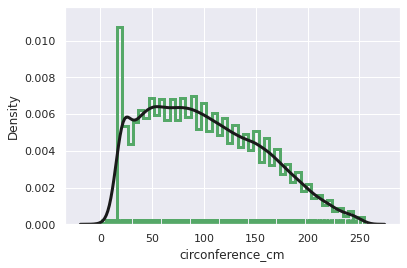

In [63]:
sns.distplot(data_filtre['circonference_cm'].loc[data['genre'] == 'Platanus'], rug=True, rug_kws={"color": "g"},

                          kde_kws={"color": "k", "lw": 3, "label": "KDE"},

                          hist_kws={"histtype": "step", "linewidth": 3,

                                    "alpha": 1, "color": "g"})

In [64]:
quant = pd.DataFrame(sklearn.preprocessing.normalize(quant_gen_filtre[['arbres','cat_age','haut', 'circon']]), columns=['arbres','cat_age','haut', 'circon'])
quant['genre'] = quant_gen_filtre['genre']
quant

,arbres,cat_age,haut,circon,genre
0,0.041707,0.062561,0.114695,0.990551,Abelia
1,0.729474,0.024281,0.084723,0.678307,Abies
2,0.235486,0.078495,0.196239,0.948617,Acacia
3,0.193122,0.144841,0.096561,0.965609,Acca
4,0.999974,0.000235,0.000806,0.007170,Acer
...,...,...,...,...,...
141,0.098017,0.054563,0.163361,0.980168,Viburnum
142,0.283481,0.070355,0.119578,0.948889,Zanthoxylum
143,0.976284,0.007756,0.026047,0.214782,Zelkova
144,0.558909,0.052398,0.120165,0.818801,x Chitalpa


sns.set_theme(style="whitegrid")

# Load the dataset
#quant = quant_gen_filtre[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(quant.sort_values("circon", ascending=True),
                 x_vars=quant.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','haut', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_circonf.png")


sns.set_theme(style="whitegrid")

# Load the dataset
#quant = quant_gen_filtre[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(quant.sort_values("haut", ascending=True),
                 x_vars=quant.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','hauteur', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_hauteur.png")


sns.set_theme(style="whitegrid")

# Load the dataset
#quant = quant_gen_filtre[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(quant.sort_values("cat_age", ascending=True),
                 x_vars=quant.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','haut', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_age.png")


sns.set_theme(style="whitegrid")

# Load the dataset
#quant = quant_gen_filtre[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(quant.sort_values("arbres", ascending=True),
                 x_vars=quant.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','haut', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_nb_arbres.png")


<AxesSubplot:xlabel='haut', ylabel='circon'>

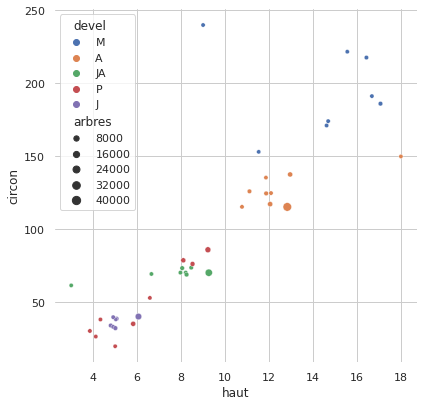

In [65]:
sns.set_theme(style="whitegrid")

df = quant_dev_dom[['haut','circon', 'arbres', 'devel']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="haut", y="circon",
                hue="devel", hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

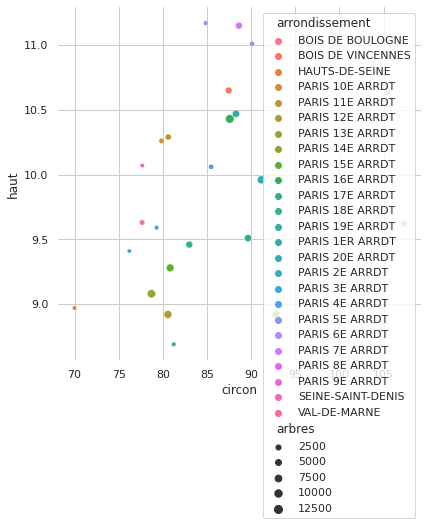

In [66]:
sns.set_theme(style="whitegrid")

df = quant_arr[['haut','circon', 'arbres', 'arrondissement']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="arrondissement", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

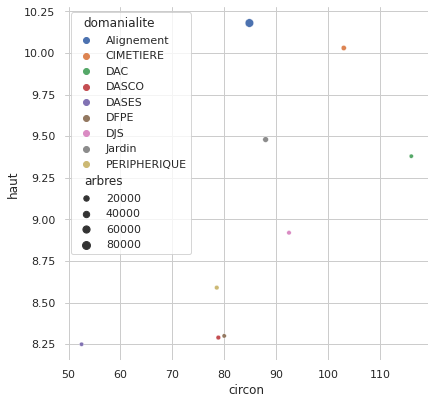

In [67]:
sns.set_theme(style="whitegrid")

df = quant_dom[['haut','circon', 'arbres', 'domanialite']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="domanialite", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

## Carte des positions

In [68]:
def cstr(s, color='green'):
    return "<text style=color:{}>{}</text>".format(color,s)
html_print("Some " + cstr('green'))

In [69]:
couleurs_list = ['#4ffb28',
         '#5fa390',
         '#ff1515',
         '#694231',#'#5b3d2a',
         '#000000'
         ]

In [70]:
couleurs_dict = dict()
for it, val in enumerate(data['stade_developpement'].unique()):
    couleurs_dict.update({val: couleurs_list[it]})
couleurs_dict

{'P': '#4ffb28',
 'A': '#5fa390',
 'J': '#ff1515',
 'M': '#694231',
 'JA': '#000000'}

In [71]:
data['couleurs'] = data['stade_developpement'].map(couleurs_dict)

In [72]:
html_print(cstr('J: #ff1515', '#ff1515') + ",\n"
 +cstr("P: #4ffb28", "#4ffb28")+',\n'
 +cstr('JA: #000000', '#000000')+',\n'
 +cstr('A: #5fa390', '#5fa390')+',\n'
 +cstr('M: #694231', '#694231')+'}\n' )

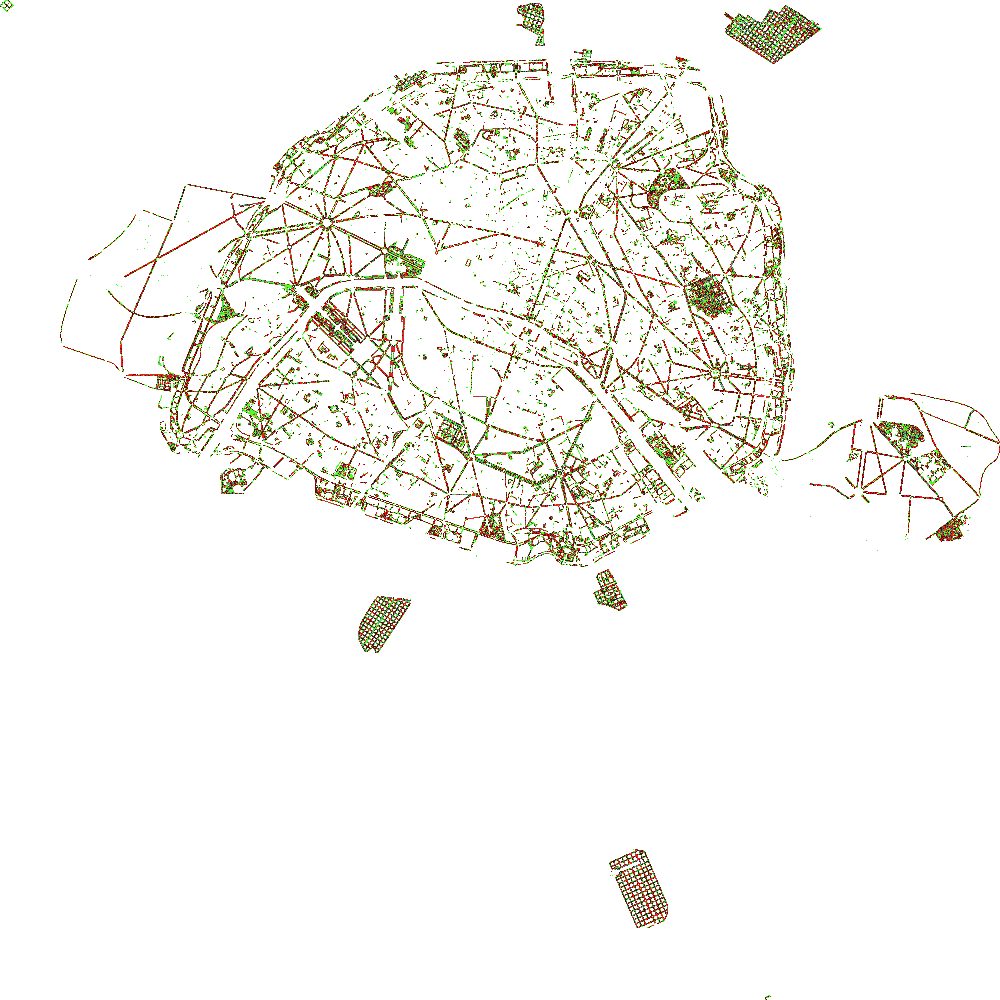

In [73]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(data, 'geo_point_2d_b', 'geo_point_2d_a')
img = ds.tf.shade(agg, cmap=list(data['couleurs']), how='eq_hist')
img

In [74]:
data_map = pd.read_excel('data/new_data_end_0.9_0.1.xlsx')

In [75]:
couleurs_list = [#'#4ffb28',
       #  '#5fa390',
    'black','red','yellow'
                #'#694231',
      # '#ff1515',
       #  '#694231',#'#5b3d2a',
       #   '#000000',
         ]

In [76]:
couleurs_dict = dict()
for it, val in enumerate(data_end['soin'].unique()):
    couleurs_dict.update({val: couleurs_list[it]})
couleurs_dict

NameError: name 'data_end' is not defined

In [ ]:
data_map['couleurs'] = data_map['soin'].map(couleurs_dict)

In [ ]:
html_print(cstr('J: #ff1515', '#ff1515') + ",\n"
 +cstr("à surveiller: #4ffb28", "#4ffb28")+',\n'
 +cstr('normal: #000000', '#000000')+',\n'
 +cstr('à vérifier: #5fa390', '#5fa390')+',\n'
 +cstr('M: #694231', '#694231')+'}\n' )

In [ ]:
data_map['couleurs'].value_counts()

In [ ]:
couleurs_dict

In [ ]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(data_map, 'geo_point_2d_b', 'geo_point_2d_a')
img = ds.tf.shade(agg, cmap=['black','cyan','red'], how='eq_hist')
img

In [ ]:
informations(data_end)

In [ ]:
poi_list = ['orange', 'blue', 'red']
    poi_icon_list = ['heart', 'ok-sign', 'question-sign']
    poi_dict = dict()
    for it, val in enumerate(data_end['soin'].unique()):
        poi_dict.update({val: poi_list[it]})
    poi_icon_dict = dict()
    for it, val in enumerate(data_end['soin'].unique()):
        poi_icon_dict.update({val: poi_icon_list[it]})
    poi_icon_dict

In [ ]:
data_map['poi'] = data_map['soin'].map(poi_dict)
data_map['poi_icon'] = data_map['soin'].map(poi_icon_dict)

In [ ]:
#data_map['geo_point_2d_b'].head()

In [ ]:
m = folium.Map(location=[48.857722, 2.321031], zoom_start=12, tiles="Stamen Terrain")
    for i in range(20000):
        folium.Marker(
            location=[data_map['geo_point_2d_a'].iloc[i], data_map['geo_point_2d_b'].iloc[i]],
            popup=str(data_map['genre'].iloc[i]) + ', ' + str(data_map['espece'].iloc[i]) + ', ' + str(
                data_map['variete'].iloc[i]) + ', ' +
                  str(data_map['libelle_francais'].iloc[i]) + ', haut. : ' + str(float(data_map['hauteur_m'].iloc[i])) +
                  'm, circ. : ' + str(float(data_map['circonference_cm'].iloc[i])) + 'cm, action à prendre : ' +
                  data_map['soin'].iloc[i],
            icon=folium.Icon(icon=data_map['poi_icon'].iloc[i], color=data_map['poi'].iloc[i]),
        ).add_to(m)

# Partie Algorithmie, Optimisation des trajets

Nous avons réalisé une analyse exploratoire de nos données, à présent, nous allons tâcher de répondre à la problèmatique du meilleur trajet, qui est un problème similaire au problème du voyageur de commerce pour lequel nous souhaitons utiliser l'algorithme de [Christofides](https://fr.wikipedia.org/wiki/Algorithme_de_Christofides). Pour cela nous utiliserons un GPU en local, pour calculer les distances entre tous les lieux, et nous lancerons l'algorithme de recherche du plus court chemin entre tous les lieux soit $6921$ éléments distincts.

Nous devons suivre le schéma suivant pour construire l'algorithme de Christofides :



![Algorithme de Christofides](christofides.png)

## Calcul du meilleur trajet

### Calcul des distances entre chaque lieu

Nous relevons 200137 points d'intérêts sur la carte. Si nous descendons dans la structure hiérarchisé de nos données, nous comprenons qu'il s'agit geo_point_2d -> id_emplacement -> lieu + complement d'adresse -> lieu -> arrondissement. C'est à dire qu'un lieu regroupe des id_emplacement, i.e. des arbres.

Comme il s'agit de trouver une tournée véhiculée, entre $6921$ lieux uniques, contenant eux-mêmes un certain nombre d'arbres (chacun), et que ces lieux sont reliés entre eux par une distance pouvant se calculer d'après la latitude et la longitude, nous utiliserons une représentation en graphe (arrête et sommet) pour trouver le meilleurs chemins, en commençant par le calcul de la matrice des distances, puis du chemin de poids minimum.

1. Nous calculerons la quantité d'arbres d'un lieu par la fonction d'aggrégeage "aggfunc" ci-dessous. Nous disposerons le résultat dans une colonne portant le nom de aire, car c'est une donnée quantitative que nous souhaitons représenter sous la forme de cercle avec plus ou moins de surface.

![Algorithme de Christofides](christofides_schema.png)

In [ ]:
df = data[['arrondissement', 'lieu', 'geo_point_2d_a', 'geo_point_2d_b', 'genre']].copy()

In [ ]:
lieu_aire = pd.DataFrame(df.pivot_table(index=['lieu'], aggfunc='size'), columns=['aire'])

In [ ]:
x = lieu_aire.reset_index()

**Nous éliminons ainsi les lieux doublons**, notons que les bulles de circonférences sont en rapport avec le nombre de ligne (et donc d'arbre) disparaissant dans cette opération.

In [ ]:
df = df.drop_duplicates(subset='lieu', ignore_index=True)

In [ ]:
set_1 = set(list(lieu_aire.index))

In [ ]:
set_2 = set(list(df['lieu']))

In [ ]:
set_2 == set_1

In [ ]:
q7 = """SELECT  df.lieu as lieu,
                df.arrondissement as arrond,
                df.geo_point_2d_a as lat,
                df.geo_point_2d_b as lon,
                x.aire as aire
                FROM df INNER JOIN x ON df.lieu == x.lieu ORDER BY lieu"""

In [ ]:
df_graph = ps.sqldf(q7, locals())

In [ ]:
df_graph

### Création de couleurs de bulles en fonction de chacun des arrondissements

Les bulles de nos lieux seront munies d'une couleur dans notre graphe pour distinguer les arrondissements.

In [ ]:
couleurs_list = ['#B22222',
         '#F08080',
         '#DC143C',
         '#FF0000',
         '#FF4500',
         '#FF8C00',
         '#FFE4B5',
         '#32CD32',
         '#008000',
         '#90EE90',
         '#808000',
         '#7FFFD4',
         '#66CDAA',
         '#48D1CC',
         '#00CED1',
         '#008080',
         '#87CEFA',
         '#1E90FF',
         '#6495ED',
         '#0000FF',
         '#000080',
         '#7B68EE',
         '#EE82EE',
         '#8A2BE2',
         '#FF69B4'
         ]

In [ ]:
couleurs_dict = dict()
for it, val in enumerate(df_graph['arrond'].unique()):
    couleurs_dict.update({val: couleurs_list[it]})

In [ ]:
df_graph['couleurs'] = df_graph['arrond'].map(couleurs_dict)

Nous exportons notre tableau trier par ordre alphabétique de lieu pour l'utiliser sur notre gpu et pour que nous réalisions le calcul de la matrice des distances entre les lieux.

2. Nous calculerons la matrices des distances entre chaque lieu sur un gpu (le code est fourni en annexe), et ce sera donc une matrice de (6921 x 6921). Une distance est donnée par la relation $\sqrt{((x_1 - x_0)*111)^2 + ((y_1 - y_0)*80)^2} ,\forall x \in latitude, \forall  y\in longitude$ en France, pour la distance en $km$. Le script de calcul de cette matrice est réalisé dans l'IDE PyCharm avec la bibliothèque PyCuda et une carte NVIDIA, localement. L'écriture du code en C ne se prête hélas pas tellement, visuellement parlant, au Notebook de Jupyter.

En sortie nous traitons notre matrice pour la retrouver dans une dataframe avec nos indexes et colonnes en nom de lieu. Comme les calculs ont été réalisés dans des "numpy arrays" les colonnes n'ont pas été nommées. Mais nous avons effectuer les calculs sur un échantillon des données avec notre cpu, puis nous importerons le fichier de résultats de 600Mo dans une DataFrame pour les comparer et voir que nous trouvons le même résultat sur un échantillon.

In [ ]:
distances_cpu = pd.DataFrame(df_graph, index=df_graph['lieu'].unique(), columns=df_graph['lieu'].unique())

In [ ]:
for it, row in enumerate(distances_cpu.iloc[:5,:5].columns):
    for it, col in enumerate(distances_cpu.iloc[:5,:5].columns):
        distances_cpu[col].loc[row] = math.sqrt(((df_graph['lat'].loc[df_graph['lieu'] == col].values - df_graph['lat'].loc[df_graph['lieu'] == row].values)*111)**2\
+ ((df_graph['lon'].loc[df_graph['lieu'] == col].values - df_graph['lon'].loc[df_graph['lieu'] == row].values)*80)**2)

distances_cpu.iloc[:5,:5]

## Code GPU de calcul de la matrice des distances 

Compte-tenu qu'il est nécessaire d'utiliser Anaconda, cela contreviendrait à la consigne qui stipule que l'exercice doit intégrer un environnement virtuel propre. Mais le code est présenté pour preuve :

Ici nous importons les résultats des calculs fait à partir de notre gpu local, sur l'heuristique des distances entre lieux. Ce fichier fait 600 Méga Octets.
Nous voyons que les échantillons ci-dessus, et ci-dessous ont des résultats semblables. Comme le chargement du fichier prend trop de temps, nous avons pris le soin de produire un échantillon de 25 lieux, et c'est lui que nous chargeons.

Nous comparons le résultat avec le tableau ci-dessous pour comprendre que tout s'est bien passé sur notre gpu et que nous pouvons travailler avec nos données.

Nous sauvegardons un échantillon de notre matrice pour pouvoir effectuer le programme sur 25 lieux :

## Problème du voyageur de commerce, algorithme de Christofides

Nous considérons un graphe G(V,E) dont les poids respectent l'égalité triangulaire $d_{ij}+d_{jk}\le d_{ik}$.

La première étape de l'écriture de cet algorithme est l'écriture un arbre couvrant le poids minimum.
Nous vous le présentons ci-dessous :

Le résultat du chemin de poids minimal à partir d'un départ aléatoir est présenté ci-dessous

Ensuite nous Calculons l'ensemble des sommets impairs :

Nous calculons un couplage de poids minimum dans l'ensemble des sommets impairs.

Nous devons faire l'union du couplage ci-dessus et de l'arbre couvrant de poids minimum.

Calculons le tour Eulérien et le tour le plus court en même temps :

Ainsi, nous avons présenté les données de la ville de Paris, nous avons effectué une analyse univariée sur les éléments chiffrés, à la suite de quoi, nous avons calculé la matrice des distances entre les lieux, en ayant éliminé les doublons. Pour la présentation future du graphe, nous avons rajouté le nombre d'arbres par lieu dans la colonne aire, et une couleur distincte par arrondissement. Enfin nous avons résolu algorithmiquement le chemin de poids minimum pour n'importe quel point de départ. Par contre l'algorithme de Christofides étant de complexité $O(x) = x^3$, il me semble bien ambitieux pour 6921 lieux, et donc aussi pour le calculer dans ce projet dans des délais raisonnables.

## Optimisation des ressources

In [ ]:
import christofides

christofides.christofides()

## Nous calculons les moyennes et les quantiles sup et inf pour les hauteurs et les circonférences

Nous travaillons à partir des données filtrées

In [ ]:
#N = 20
q_h = 0.85
q_b = 0.15
mean = pd.DataFrame()
std = pd.DataFrame()
data_filtre_moy_qut = pd.DataFrame()
for arr in list(data_filtre['libelle_francais'].unique()):
    for age in list(data_filtre['stade_developpement'].unique()):
        mean = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].mean()
        std = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].std()  
        qut_h = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_h)  
        qut_b = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_b)  
        data_filtre_moy_qut = data_filtre_moy_qut.append({'libel':arr, 'age':age, 'quantite_var_par_age': 
                        int(data_filtre['type_emplacement'].loc[(data_filtre['libelle_francais'] == arr) &
                                                                (data_filtre['stade_developpement'] == age)].count()),                    
                        'avg_h': mean['hauteur_m'], 'std_h': std['hauteur_m'], 'qut_h_h':qut_h['hauteur_m'],'qut_h_b':qut_b['hauteur_m'],
                       'avg_c': mean['circonference_cm'], 'std_c': std['circonference_cm'], 'qut_c_h': qut_h['circonference_cm'], 'qut_c_b': qut_b['circonference_cm']}, 
                       ignore_index=True)


Nous récupérons cela dans une dataframe que nous nommons data_filtre_moy_qut

In [ ]:
data_filtre_moy_qut = data_filtre_moy_qut.convert_dtypes()
data_filtre_moy_qut['quantite_var_par_age'] = data_filtre_moy_qut['quantite_var_par_age'].astype('int32', copy=False)
data_filtre_moy_qut.info()

In [ ]:
data_filtre_moy_qut[['libel','age','quantite_var_par_age','avg_h','std_h', 'qut_h_h', 'qut_h_b','avg_c','std_c', 'qut_c_h', 'qut_c_b']].sort_values(by=['libel','age']).reset_index()

In [ ]:
data_filtre['libelle_francais'].loc[data_filtre['libelle_francais'] == ''].count()

In [ ]:
q8 = """SELECT  data_filtre_moy_qut.libel,
                    data_filtre_moy_qut.age,
                    data_filtre_moy_qut.quantite_var_par_age,
                    data_filtre_moy_qut.avg_h,
                    data_filtre_moy_qut.qut_h_h,
                    data_filtre_moy_qut.qut_h_b,
                    data_filtre_moy_qut.std_h,
                    data_filtre_moy_qut.avg_c,
                    data_filtre_moy_qut.qut_c_h,
                    data_filtre_moy_qut.qut_c_b,
                    data_filtre_moy_qut.std_c,
                    data_filtre.type_emplacement,
                    data_filtre.domanialite,
                    data_filtre.arrondissement,
                    data_filtre.complement_addresse,
                    data_filtre.lieu,
                    data_filtre.id_emplacement,
                    data_filtre.genre,
                    data_filtre.espece,
                    data_filtre.variete,
                    data_filtre.hauteur_m,
                    data_filtre.stade_developpement,
                    data_filtre.circonference_cm,
                    data_filtre.remarquable,
                    data_filtre.sta_dev_num,
                    data_filtre.geo_point_2d_a as lat,
                    data_filtre.geo_point_2d_b as lon
                FROM data_filtre 
                JOIN data_filtre_moy_qut 
                ON data_filtre_moy_qut.libel = data_filtre.libelle_francais 
                AND data_filtre.stade_developpement = data_filtre_moy_qut.age """

In [ ]:
actions = ps.sqldf(q8, locals())

In [ ]:
actions.libel.loc[actions['libel'] == 'Marronnier'].count()

## Dépose d'un marqueur de soin concernant la santé de l'arbre.

In [ ]:
actions['sante'] = ''
actions['soin'] = ''

In [ ]:
load = actions.copy()

In [ ]:
for lib in list(load.libel.unique()):
    load.loc[actions['libel'] == lib,'nb_arbre_meme_libel'] = load.libel.loc[actions['libel'] == lib].count()
for arr in list(load.arrondissement.unique()):
    load.loc[actions['arrondissement'] == arr,'nb_arbre_meme_arr'] = load.arrondissement.loc[actions['arrondissement'] == arr].count()
for lib in list(load.libel.unique()):
    for arr in list(load.arrondissement.unique()):
        load.loc[(actions['arrondissement'] == arr)&(actions['libel'] == lib),'nb_arbre_meme_libel_arr'] = load.arrondissement.loc[(actions['arrondissement'] == arr)&(actions['libel'] == lib)].count()


In [ ]:
load['nb_arbre_meme_libel'].sort_values()

In [ ]:
load['nb_arbre_meme_arr'].sort_values()

In [ ]:
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'sante'] = 'au-dessous'
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'soin'] = 'à surveiller'
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_c'] = load['qut_c_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_h'] = load['qut_h_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]

In [ ]:
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'sante'] = 'au-dessus'
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'soin'] = 'à surveiller'
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_c'] = load['qut_c_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_h'] = load['qut_h_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]
load['sante'].value_counts()

In [ ]:
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'sante'] = 'norm'
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'soin'] = 'normal'
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_c'] = load['avg_c'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_h'] = load['avg_h'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]


In [ ]:
load.sante.value_counts()

In [ ]:
#for arr in list(load.arrondissement.unique()):
    #load.loc[((actions['arrondissement'] == arr)&(actions['soin'] == 'à surveiller')),'nb_arbre_surveiller_arr'] = load.arrondissement.loc[actions['arrondissement'] == arr].count()
#for lieu in list(load.lieu.unique()):
#load.loc[((actions['lieu'] == lieu)&(actions['soin'] == 'à surveiller')),'nb_arbre_surveiller_lieu'] = load.lieu.loc[actions['lieu'] == lieu].coun

In [ ]:
actions = load.copy()

In [ ]:
actions.columns

In [ ]:
data_basse = actions.loc[(actions['hauteur_m'] <= actions['qut_h_b'])&(actions['circonference_cm'] <= actions['qut_c_b'])].copy()

In [ ]:
data_haute = actions.loc[(actions['hauteur_m'] >= actions['qut_h_h'])&(actions['circonference_cm'] >= actions['qut_c_h'])].copy()

In [ ]:
# for age in list(actions.unique()):
sns.set_theme(style="whitegrid")

#df_age_quant_sante = actions[['avg_h','sante', 'avg_c', 'Quantite']].loc[actions['age'] == 'A']# age instead of 'J'

f, ax = plt.subplots(figsize=(8.5, 8.5))
sns.despine(f, left=True, bottom=True)
plt.title(str(actions['libel'].loc[actions['soin']=='à surveiller'].count()) + ' arbres à surveiller\n' 
          +str(actions['libel'].loc[actions['soin']=='normal'].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
#plt.xscale('Symlog')
#plt.yscale('Symlog')
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue="sante", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age', size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']], ci="sd",ax=ax)
f.savefig('draft/arbres_surveillance_lineaire_' + str(q_h) +'_'+ str(q_b)+ '.png')
plt.clf()
plt.close('all')

In [ ]:
# for age in list(actions.unique()):
sns.set_theme(style="whitegrid")

#df_age_quant_sante = actions[['avg_h','sante', 'avg_c', 'Quantite']].loc[actions['age'] == 'A']# age instead of 'J'

f, ax = plt.subplots(figsize=(8.5, 8.5))
sns.despine(f, left=True, bottom=True)
plt.title(str(actions['libel'].loc[actions['soin']=='à surveiller'].count()) + ' arbres à surveiller\n' 
          +str(actions['libel'].loc[actions['soin']=='normal'].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Symlog')
plt.yscale('Linear')
#clarity_ranking = ['M','A','JA','P';'J']
sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue="soin", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age', size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']], ci="sd",ax=ax)
f.savefig('draft/arbre_norm_surv_par_age_' + str(q_h) +'_'+ str(q_b)+ '.png')
plt.clf()
plt.close('all')

In [ ]:
# for age in list(actions.unique()):
sns.set_theme(style="whitegrid")

#df_age_quant_sante = actions[['avg_h','sante', 'avg_c', 'Quantite']].loc[actions['age'] == 'A']# age instead of 'J'
arr_list = [

 'PARIS 1ER ARRDT',
 'PARIS 2E ARRDT',
 'PARIS 3E ARRDT',
 'PARIS 4E ARRDT',
 'PARIS 5E ARRDT',
 'PARIS 6E ARRDT',
 'PARIS 7E ARRDT',
 'PARIS 8E ARRDT',
 'PARIS 9E ARRDT',
 'PARIS 10E ARRDT',
 'PARIS 11E ARRDT',
 'PARIS 12E ARRDT',
 'PARIS 13E ARRDT',
 'PARIS 14E ARRDT',
 'PARIS 15E ARRDT',
 'PARIS 16E ARRDT',
 'PARIS 17E ARRDT',
 'PARIS 18E ARRDT',
 'PARIS 19E ARRDT',
 'PARIS 20E ARRDT',
 'BOIS DE BOULOGNE',
 'BOIS DE VINCENNES',
 'HAUTS-DE-SEINE',
 'SEINE-SAINT-DENIS',
 'VAL-DE-MARNE']
f, ax = plt.subplots(figsize=(12.5, 15.5))
sns.despine(f, left=True, bottom=True)
plt.title('Les arbres à surveiller par arrondissement',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Symlog')
plt.yscale('Linear')#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue_order=arr_list,
                hue="arrondissement", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age',
                 size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']].loc[actions['soin']=='à surveiller'], ci='sd',ax=ax)
f.savefig('draft/data_arbre_a_surveiller_par_arrondissement_q_h_' + str(q_h) +'_'+ str(q_b)+ '.png')
plt.clf()
plt.close('all')

In [ ]:
actions

### Analyse du nombre d'arbre par arrondissement.

In [ ]:
q9 = """SELECT actions.arrondissement as arr, 
                COUNT(*) as total
                FROM actions
       GROUP BY actions.arrondissement
"""

In [ ]:
actions_hist = ps.sqldf(q9, locals())

In [ ]:
actions_hist

In [ ]:
q10 = """SELECT actions.arrondissement as arr, 
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.arrondissement
"""

In [ ]:
actions_hist_soin = ps.sqldf(q10, locals())

In [ ]:
actions_hist_soin

In [ ]:
q11 = """SELECT actions_hist.arr as arr, 

                actions_hist.total,
                actions_hist_soin.surveiller 
                FROM actions_hist JOIN actions_hist_soin ON actions_hist.arr = actions_hist_soin.arr


"""


In [ ]:

actions_hist_merge = ps.sqldf(q11, locals())

In [ ]:
actions_hist_merge

In [ ]:
data_hist_chart = actions_hist_merge.copy()

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 15))

# Load the example car crash dataset
crashes = data_hist_chart
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(order=arr_list,x="total", y="arr", data=crashes,
            label="Normaux", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(order=arr_list,x="surveiller", y="arr", data=crashes,
            label="à Surveiller", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 15000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)
f.savefig('draft/arbre_a_surveiller_par_arrondissement_q_h_' + str(q_h) +'_'+ str(q_b)+ '.png')
plt.clf()
plt.close('all')

### Analyse du nombre d'arbre par arrondissement et par stade de développement.

In [ ]:
qa9 = """SELECT actions.arrondissement as arr, 
                actions.age,
                COUNT(*) as total
                FROM actions
       GROUP BY actions.arrondissement, actions.age
"""

In [ ]:
actions_hist_stadev = ps.sqldf(qa9, locals())

In [ ]:
actions_hist_stadev

In [ ]:
qa10 = """SELECT actions.arrondissement as arr, 
                actions.age,
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.arrondissement, actions.age
"""

In [ ]:
actions_hist_stadev_soin = ps.sqldf(qa10, locals())

In [ ]:
actions_hist_stadev_soin

In [ ]:
qa11 = """SELECT actions_hist_stadev.arr as arr, 
                actions_hist_stadev.age,
                actions_hist_stadev.total,
                actions_hist_stadev_soin.surveiller 
                FROM actions_hist_stadev JOIN actions_hist_stadev_soin ON actions_hist_stadev.arr = actions_hist_stadev_soin.arr AND
                actions_hist_stadev.age = actions_hist_stadev_soin.age

"""


In [ ]:

actions_hist_stadev_merge = ps.sqldf(qa11, locals())

In [ ]:
actions_hist_stadev_merge

In [ ]:
data_hist__stdev_chart = actions_hist_stadev_merge.copy()

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 15))

# Load the example car crash dataset
crashes = data_hist__stdev_chart
# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(order=arr_list, hue_order=['J','P','JA','A','M'],x="total", y="arr", hue="age", data=crashes,
             color="g")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 15000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)
#f.savefig('draft/arbre_a_surveiller_par_arrondissement_q_h_' + str(q_h) +'_'+ str(q_b)+ '.png')
plt.clf()
plt.close('all')

### Analyse des arbres les plus fréquents par arrondissement

In [ ]:
actions.columns

In [ ]:
freq_libel_arr = actions[['arrondissement', 'libel','nb_arbre_meme_libel_arr']].copy()

In [ ]:
freq_libel_arr = freq_libel_arr[~freq_libel_arr.duplicated()].sort_values(by='arrondissement')

In [ ]:
freq = pd.DataFrame()
for arr in list(freq_libel_arr['arrondissement'].unique()):
    freq =freq.append(freq_libel_arr.loc[freq_libel_arr['arrondissement'] == arr].sort_values(by='nb_arbre_meme_libel_arr').iloc[-5:])

In [ ]:
freq_libel_arr.rename(columns={'libel':'libelle_francais'}).to_excel('data_freq_libel_arr.xlsx')

In [ ]:
freq

In [ ]:
len(arr_list)

In [ ]:
f, ax = plt.subplots(figsize=(60, 60))
A = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[0::5]))
B = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[1::5]))
C = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[2::5]))
D = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[3::5]))
E = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[4::5]))
Pos = range(25)
plt.bar(Pos, A)
plt.bar(Pos, B, bottom = A)
plt.bar(Pos, C, bottom = A + B)
plt.bar(Pos, D, bottom = A + B + C)
plt.bar(Pos, E, bottom = A + B + C + D)
plt.xticks(Pos, arr_list)
plt.title('La part des 5 libellés les plus fréquents par arrondissement', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
f.savefig('img/part_des_5_libels_freq_par_arrondissement_' + str(q_h) +'_'+ str(q_b)+ '.png')
plt.show() 

In [ ]:
f, ax = plt.subplots(figsize=(18, 15))
sns.barplot(data=freq, dodge=True,order=arr_list,y="arrondissement", x="nb_arbre_meme_libel_arr", orient='h')#, multiple="stack")
#sns.histplot(data=freq, x="arrondissement", y='nb_arbre_meme_libel_arr', hue="libel", multiple="stack")
plt.title()
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')

In [ ]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(order=['J','P','JA','A','M'],x="age", y="circonference_cm", data=actions, inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
#ax = sns.stripplot(order=['J','P','JA','A','M'],x="age",hue="remarquable", y="quantite_var_par_age", data=actions)
f.savefig('draft/repartition_des_varietes_par_age_par_remarquable.png')

In [ ]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(order=['J','P','JA','A','M'],x="age", y="hauteur_m", data=actions, inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
#ax = sns.stripplot(order=['J','P','JA','A','M'],x="age",hue="remarquable", y="quantite_var_par_age", data=actions)
f.savefig('draft/repartition_des_varietes_par_age_par_remarquable.png')

In [ ]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(x="domanialite",hue="remarquable", y="quantite_var_par_age", data=actions, inner=None, scale='width')
#ax = sns.despine(offset=20, trim=True);
#ax = sns.stripplot(order=['J','P','JA','A','M'],x="age",hue="remarquable", y="quantite_var_par_age", data=actions)
f.savefig('draft/repartition_des_varietes_par_domanialite_par_remarquable.png')

In [ ]:
q12 = """SELECT actions.lieu as lieu, 
                actions.arrondissement,
                COUNT(*) as total
                FROM actions
       GROUP BY actions.lieu
"""

In [ ]:
actions_hist_lieu = ps.sqldf(q12, locals())

In [ ]:
actions_hist_lieu.loc[actions_hist_lieu['lieu']== 'JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH']

In [ ]:
q13 = """SELECT actions.lieu as lieu, 
                actions.arrondissement,
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.lieu
"""

In [ ]:
actions_hist_lieu_soin = ps.sqldf(q13, locals())

In [ ]:
actions_hist_lieu_soin

In [ ]:
q14 = """SELECT actions_hist_lieu_soin.lieu as lieu, 
                actions_hist_lieu.arrondissement,
                actions_hist_lieu.total,
                actions_hist_lieu_soin.surveiller 
                FROM actions_hist_lieu JOIN actions_hist_lieu_soin ON actions_hist_lieu.lieu = actions_hist_lieu_soin.lieu


"""


In [ ]:

actions_hist_lieu_merge = ps.sqldf(q14, locals())

In [ ]:
actions_hist_lieu_merge

In [ ]:
f = plt.figure(figsize=(10 , 10))
ax = actions_hist_lieu_merge['surveiller'].plot()
#f.figsave('plot.png')
plt.title('Nombre d\'arbre à surveiller à chaque lieu', fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.xlabel('Lieu')
plt.ylabel('arbres à surveiller')
plt.savefig('draft/plot_surveiller_lieu.png')


In [ ]:
chemin_note = pd.read_pickle('chemin.dat_0.95_0.05')

In [ ]:
road_dict_df = dict()
for i in arr_list:
    road_dict_df.update({i:chemin_note['road'][i]})

In [ ]:
road_df = pd.DataFrame.from_dict(road_dict_df, orient='index')

In [ ]:
road_df.transpose().to_excel('chemin_par_arrondissement.xlsx')

In [ ]:
actions_simple = pd.read_excel('data/actions_0.95_0.05.xlsx')

In [ ]:
actions_simple.columns

In [ ]:
data_filtre.columns

In [ ]:
actions_simple = actions_simple.rename(columns={'lat':'geo_point_2d_a', 'lon':'geo_point_2d_b'})

In [ ]:
action_df_simple = actions_simple[['type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais',
       'genre', 'espece', 'variete', 'circonference_cm', 'hauteur_m',
       'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b', 'soin']].copy()

In [ ]:
action_df_simple.count()

In [ ]:
data.loc[((data["hauteur_m"] >= 21) | (data["hauteur_m"] <= 0)) \
                          | ((data["circonference_cm"] >= 255) | (data["circonference_cm"] <= 0))].count()

In [ ]:
data_new = data.loc[((data["hauteur_m"] >= 21) | (data["hauteur_m"] <= 0)) \
                          | ((data["circonference_cm"] >= 255) | (data["circonference_cm"] <= 0))].copy()

In [ ]:
data_new['soin'] = 'à vérifier'

In [ ]:
data_end = action_df_simple.append(data_new).copy()

In [ ]:
data_end = data_end.drop(['sta_dev_num','couleurs'], axis=1)

In [ ]:
data_end['soin'].value_counts()